## Statistical analysis of the MovieLens 1m dataset

Like Wan et al., we split a user's move preferences into (1) the user's willingness to consume (watch) a movie, and (2) the user's satisfaction feedback (rating) after they have seen the movie.

The following analysis are purely observational and aim to identify bias across these two aspects. 



Code adapted from Wan et al.'s Github repository: https://github.com/MengtingWan/marketBias/blob/master/analysis.ipynb

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.stats import chi2_contingency, ttest_ind, ttest_rel, f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns

%matplotlib inline
rc('pdf', fonttype=42)

Note to avoid modifying Wan et al.'s code significantly, we named the dataframe columns in the same way that they did, so `model_attr` in our context is the gender stereotype assigned to a movie. Movies can be gendered based on how they are marketed, stereotypical genres that males tend to like more than females (e.g. stereotypes could be that males like horror, females like romantic comedies), the gender composition of the main cast, etc. 

In [30]:
def contingency_table(df_review, columns=[]):
    tab = pd.crosstab(df_review['model_attr'], df_review['user_attr'], margins=True)
    if len(columns) > 0:
        tab = tab[columns]
    print('contingency table')
    tab.index = tab.index.rename('movie_gender')
    tab.columns = tab.columns.rename('user_gender')
    display(tab)
    
    tab = df_review.groupby(['model_attr', 'user_attr'])['rating'].size().unstack()
    #tab.index)
    if len(columns)>1:
        tab = tab[columns[:-1]]
    g, p, dof, expected = chi2_contingency(tab.values)
    print('chi2', g.round(3), 'p-value', p.round(3))
    print('')
    print('real market size - expected market size')
    display((tab-expected).round(2))
    
def two_way_anova(df_review, metric):
    test3 = sm.stats.anova_lm(
        ols(metric+' ~ model_attr*user_attr', data=df_review).fit()).values[:3,-2:]
    df = pd.DataFrame(test3,
                      columns=['F-stat', 'p-value'], 
                      index=['product', 'user', 'product:user'])
    display(df.round(3))
    return df

def plot_avg_by_segment(df_review, metric, figsize, index=[], dump=True):
    fig = plt.figure(figsize=figsize)
    group_rating = df_review.groupby(['user_attr', 'model_attr'])[metric].mean().unstack()
    group_std = 1.96*df_review.groupby(['user_attr', 'model_attr'])[metric].sem().unstack()
    if len(index)>0:
        group_rating = group_rating.loc[index]
    group_rating.index = group_rating.index.rename('user identity')
    group_rating.columns = group_rating.columns.rename('product image')
    text = []
    for ri in range(group_rating.shape[0]):
        row = []
        for ci in range(group_rating.shape[1]):
            row.append(str(group_rating.values[ri, ci].round(2))+'\n('+r'$\pm$'+str(group_std.values[ri, ci].round(2))+')')
        text.append(row)
    text = np.array(text)
    
    sns.heatmap(group_rating, annot=text, fmt='s', cmap="YlGnBu", annot_kws={"size": 13},
                cbar=False)
    if dump:
        fig.savefig('./figures/movielens.ratings_obs_heatmap.pdf', bbox_inches='tight')

In [13]:
df_review = pd.read_csv('./data/df_movielens_1m.csv')
df_review['timestamp'] = df_review['timestamp'].apply(
    lambda d: datetime.fromtimestamp(d).strftime('%Y-%m-%d'))
df_review['timestamp'] = pd.to_datetime(df_review['timestamp'])

In [14]:
nh_df_review = pd.read_csv('./data/df_movielens_1m.no_horror.csv')
nh_df_review['timestamp'] = nh_df_review['timestamp'].apply(
    lambda d: datetime.fromtimestamp(d).strftime('%Y-%m-%d'))
nh_df_review['timestamp'] = pd.to_datetime(nh_df_review['timestamp'])

Our null hypothesis is that the gender stereotype of movies and user gender is statistically independent. Our Chi-squared test shows that we will reject the null hypothesis with a large Chi^2 and significant p-value. 

The contingency table of the frequency distribution of movie gender stereotype and user gender confirms self-congruity (i.e. movies perceived as 'male' movies are watched by more male users).

In [31]:
contingency_table(df_review)  # all data

contingency table


user_gender,F,M,All
movie_gender,,,
F,52609,107022,159631
M,159722,562465,722187
MF,34109,84282,118391
All,246440,753769,1000209


chi2 9532.152 p-value 0.0

real market size - expected market size


user_attr,F,M
model_attr,,
F,13277.76,-13277.76
M,-18216.58,18216.58
MF,4938.82,-4938.82


In [32]:
contingency_table(nh_df_review)  # without horror movies

contingency table


user_gender,F,M,All
movie_gender,,,
F,52344,106351,158695
M,145667,502303,647970
MF,33794,83364,117158
All,231805,692018,923823


chi2 8487.621 p-value 0.0

real market size - expected market size


user_attr,F,M
model_attr,,
F,12524.37,-12524.37
M,-16921.16,16921.16
MF,4396.80,-4396.80


User satisfaction as a function of movie genre and user identity, using 2-way analysis of variance (ANOVA). Rating scores = user satisfaction with the movie. 

Null hypotheses:
- `product`: average user satisfaction is equal across different movie genres
- `user`: average user satisfaction is equal across different user identity groups
- `product:user` no interact effect between movie genre and user groups w.r.t satisfaction

To reject the null hypothesis, we would expect F-statistic (between-group variation / within-group variation) to be high with significant p-value.

In [8]:
_ = two_way_anova(df_review, 'rating')

,F-stat,p-value
product,832.524,0.0
user,338.596,0.0
product:user,178.568,0.0


In [9]:
_ = two_way_anova(nh_df_review, 'rating')

,F-stat,p-value
product,596.893,0.0
user,310.491,0.0
product:user,182.682,0.0


Heatmap of sample means and their 95% confidence intervals. 

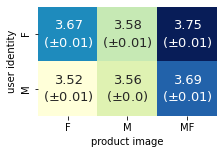

In [10]:
plot_avg_by_segment(df_review, 'rating', (3.2,2), [], dump=False)

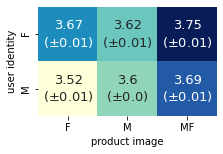

In [11]:
plot_avg_by_segment(nh_df_review, 'rating', (3.2,2), [], dump=False)